In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels

In [2]:
# Set seed for results reproducibility 
seed = 42

In [3]:
df = pd.read_excel("./Resources/deducciones_netos_acumulado.xls", index_col=0)
# Drop the null rows
df = df.dropna()
df.head()

,Desc Vales,Desc Zapatos,Otras Deducc,Desc Fonacot,Pension Alim,Desc Infonav,Faltas,Inca Enferme,Inca Riesgo,ISPT,Ajus ISPT,IMSS,Sub P/Empleo,Tot Per Grav,Tot Per Exce,Total Percep,Total Deducc,Neto Pagado
Codigo,,,,,,,,,,,,,,,,,,
8071,13,0,0.00,0.0,0,0.00,0.00,0.0,0.0,88.52,0,253.68,437.04,12333.78,2479.66,14813.44,355.20,14458.24
7840,5,0,0.00,0.0,0,0.00,228.70,0.0,0.0,864.95,0,242.62,0.00,10734.13,2316.20,13050.33,1341.27,11709.06
7879,23,0,0.00,0.0,0,0.00,120.51,0.0,0.0,946.89,0,555.13,471.83,28816.43,5406.52,34222.95,1645.53,32577.42
7505,6,0,53.33,0.0,0,0.00,602.55,0.0,0.0,339.55,0,156.15,158.65,9471.06,1119.89,10590.95,1157.58,9433.37
6600,43,0,0.00,0.0,0,6750.72,721.00,432.6,576.8,235.92,0,919.17,1474.21,42410.70,10310.47,52721.17,9679.21,43041.96


In [4]:
df1 = pd.read_excel("./Resources/DATOS_acumulado.xls", index_col=0)
# Drop the null rows
df1 = df1.dropna()
df1.head()

,Nombre,Fecha nac,Sexo,Edo Civi,Lugar de Nacimiento,Curp,Rfc,N.S.S.,Departamento,F.Ingreso,...,Regimen Fiscal,Riesgo,Puesto,status,DEPTO#,GENERO,E_CIVIL,Antig,Edad,status_bin
Codigo,,,,,,,,,,,,,,,,,,,,,
366,YADIRA MIRASET FERNANDEZ TRIGUEROS,1969-03-21,FEMENINO,CASADO,DISTRITO FEDERAL,FETY690321MDFRR,FETY690321TH,37986901918,SUPERVISION,2011-10-17,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,6,1,2,2942,18492,1
2897,JOAQUINA NARCISA CABRERA ZEPEDA,1959-10-29,FEMENINO,CASADO,DISTRITO FEDERAL,CAZJ591029MDFBP,CAZJ591029R6,64845911755,LALA VALLEJO,2017-01-13,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,51,1,2,1027,21923,1
3221,MANUEL XAVIER PE¥A LOZANO,1965-10-12,MASCULINO,CASADO,NUEVO LEON,PELM651012HNLXZ,PELM651012TW,45006502145,SERVIGAM,2018-06-18,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,11,2,2,506,19748,1
3318,JOSE LUIS HERNANDEZ BALTAZAR,1963-01-08,MASCULINO,CASADO,DISTRITO FEDERAL,HEBL630108HDFRL,HEBL630108FT,75826302426,BBVA TECNOPARQUE,2008-11-24,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,81,2,2,3999,20756,1
3321,VICENTE CRUZ SALAZAR,1965-02-12,MASCULINO,CASADO,DISTRITO FEDERAL,CUSV650212HDFRL,CUSV650212G3,1886506268,PRODUCTOS DE UVA,2010-09-07,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,4,2,2,3347,19990,1


In [5]:
df_full = pd.merge(df, df1, how='inner', on="Codigo", left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

# Read the CSV and Perform Basic Data Cleaning

In [6]:
df_full.dropna(how='all', axis=1)
df_full.head()

,Desc Vales,Desc Zapatos,Otras Deducc,Desc Fonacot,Pension Alim,Desc Infonav,Faltas,Inca Enferme,Inca Riesgo,ISPT,...,Regimen Fiscal,Riesgo,Puesto,status,DEPTO#,GENERO,E_CIVIL,Antig,Edad,status_bin
Codigo,,,,,,,,,,,,,,,,,,,,,
214,43,0,0.0,0.0,0,0.00,0.0,0.0,0.0,22408.50,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,6,1,1,1038,16544,1
236,25,0,0.0,0.0,0,13847.70,0.0,0.0,0.0,6975.97,...,2 SUELDOS Y SALARIOS,2 CLASE,II,baja,45,1,1,7353,21130,0
366,43,0,179.0,0.0,0,0.00,0.0,0.0,0.0,15443.39,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,6,1,2,2942,18492,1
442,43,0,0.0,0.0,0,0.00,0.0,0.0,0.0,4684.70,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,5,2,1,7601,19131,1
449,43,0,2550.0,0.0,0,18568.96,144.2,0.0,0.0,4050.72,...,2 SUELDOS Y SALARIOS,2 CLASE,II,activo,5,2,1,10920,18056,1


# Select your features (columns)

In [7]:
# Set features. This will also be used as your x values.
df_3 = df_full[["Desc Vales","Desc Zapatos","Otras Deducc","Desc Fonacot","Pension Alim","Desc Infonav","Faltas","Inca Enferme",
       "Inca Riesgo","ISPT","Ajus ISPT","IMSS","Sub P/Empleo","Tot Per Grav","Tot Per Exce","Total Percep","Total Deducc",
       "Neto Pagado","GENERO","E_CIVIL","DEPTO#","Tipo Jorna","Antig","Edad"]]
df_3.head()

,Desc Vales,Desc Zapatos,Otras Deducc,Desc Fonacot,Pension Alim,Desc Infonav,Faltas,Inca Enferme,Inca Riesgo,ISPT,...,Tot Per Exce,Total Percep,Total Deducc,Neto Pagado,GENERO,E_CIVIL,DEPTO#,Tipo Jorna,Antig,Edad
Codigo,,,,,,,,,,,,,,,,,,,,,
214,43,0,0.0,0.0,0,0.00,0.0,0.0,0.0,22408.50,...,28757.41,193623.11,27671.11,165952.00,1,1,6,1,1038,16544
236,25,0,0.0,0.0,0,13847.70,0.0,0.0,0.0,6975.97,...,65800.80,131846.68,22411.56,109435.12,1,1,45,1,7353,21130
366,43,0,179.0,0.0,0,0.00,0.0,0.0,0.0,15443.39,...,24766.52,157024.60,19615.10,137409.50,1,2,6,1,2942,18492
442,43,0,0.0,0.0,0,0.00,0.0,0.0,0.0,4684.70,...,15225.74,87637.44,6391.22,81246.22,2,1,5,1,7601,19131
449,43,0,2550.0,0.0,0,18568.96,144.2,0.0,0.0,4050.72,...,10415.44,81527.53,27013.69,54513.84,2,1,5,1,10920,18056


In [8]:
df_3[["Desc Vales","Desc Zapatos","Otras Deducc","Desc Fonacot","Pension Alim","Desc Infonav","Faltas","Inca Enferme",
       "Inca Riesgo","ISPT","IMSS","Total Deducc"]]*=-1
df_3.head()

C:\Users\Gonzalo\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Desc Vales,Desc Zapatos,Otras Deducc,Desc Fonacot,Pension Alim,Desc Infonav,Faltas,Inca Enferme,Inca Riesgo,ISPT,...,Tot Per Exce,Total Percep,Total Deducc,Neto Pagado,GENERO,E_CIVIL,DEPTO#,Tipo Jorna,Antig,Edad
Codigo,,,,,,,,,,,,,,,,,,,,,
214,-43,0,-0.0,-0.0,0,-0.00,-0.0,-0.0,-0.0,-22408.50,...,28757.41,193623.11,-27671.11,165952.00,1,1,6,1,1038,16544
236,-25,0,-0.0,-0.0,0,-13847.70,-0.0,-0.0,-0.0,-6975.97,...,65800.80,131846.68,-22411.56,109435.12,1,1,45,1,7353,21130
366,-43,0,-179.0,-0.0,0,-0.00,-0.0,-0.0,-0.0,-15443.39,...,24766.52,157024.60,-19615.10,137409.50,1,2,6,1,2942,18492
442,-43,0,-0.0,-0.0,0,-0.00,-0.0,-0.0,-0.0,-4684.70,...,15225.74,87637.44,-6391.22,81246.22,2,1,5,1,7601,19131
449,-43,0,-2550.0,-0.0,0,-18568.96,-144.2,-0.0,-0.0,-4050.72,...,10415.44,81527.53,-27013.69,54513.84,2,1,5,1,10920,18056


In [9]:
#df_3["Puesto"] = df_3["Puesto"].apply(lambda row: label(row))
X = df_3
y = df_full["status_bin"]

C:\Users\Gonzalo\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 4 10 21] are constant.
  UserWarning)
C:\Users\Gonzalo\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


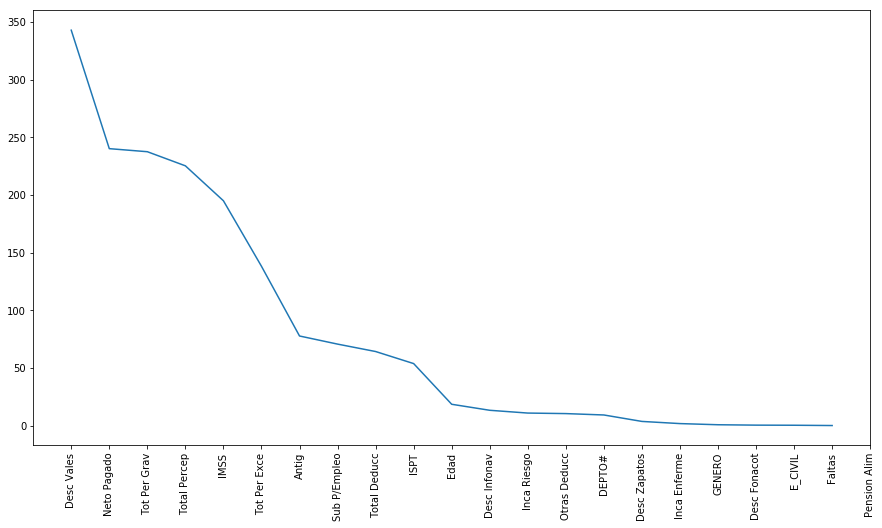

In [10]:
# Apply Univariate Feature Selection 
skb = SelectKBest(f_classif, k='all')
fit = skb.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
feat_scores = pd.concat([df_columns,df_scores],axis=1)
feat_scores.columns = ['Feature','Score'] 
feat_scores = feat_scores.sort_values(by=['Score'], ascending=False)

# Plot features to compare significative scores
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(feat_scores.Feature, feat_scores.Score)
plt.xticks(rotation=90)
plt.show()

# Create a Train Test Split

Use `status_bin` for the y values

In [11]:
# Select 11 features with highest score
sel_columns = feat_scores.iloc[0:11, 0].values

# Slice dataframe based on the selected features
X_featSel = X[sel_columns]

In [22]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_featSel, y, random_state=seed)

# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [23]:
# Scale your data
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
# Transform the training and testing data using the X_scaler

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

C:\Users\Gonzalo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gonzalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Gonzalo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [24]:
len(X_train_scaled[0])

11

In [25]:
len(X_test_scaled[0])

11

In [26]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [27]:
# Step 2: Convert encoded labels to one-hot-encoding
# ohe = 
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

#y_train_categorical = y_train_categorical[0]

# Train the Model



In [36]:
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [42]:
# fit model on training data
model = XGBClassifier()
eval_set = [(X_train_scaled, y_train)]
model.fit(X_train_scaled, y_train,eval_metric="error", eval_set=eval_set, verbose=True)


[0]	validation_0-error:0.188776
[1]	validation_0-error:0.188776
[2]	validation_0-error:0.188776
[3]	validation_0-error:0.188776
[4]	validation_0-error:0.165816
[5]	validation_0-error:0.165816
[6]	validation_0-error:0.165816
[7]	validation_0-error:0.135204
[8]	validation_0-error:0.165816
[9]	validation_0-error:0.135204
[10]	validation_0-error:0.137755
[11]	validation_0-error:0.137755
[12]	validation_0-error:0.137755
[13]	validation_0-error:0.137755
[14]	validation_0-error:0.127551
[15]	validation_0-error:0.132653
[16]	validation_0-error:0.130102
[17]	validation_0-error:0.132653
[18]	validation_0-error:0.127551
[19]	validation_0-error:0.127551
[20]	validation_0-error:0.127551
[21]	validation_0-error:0.127551
[22]	validation_0-error:0.135204
[23]	validation_0-error:0.127551
[24]	validation_0-error:0.125
[25]	validation_0-error:0.122449
[26]	validation_0-error:0.122449
[27]	validation_0-error:0.119898
[28]	validation_0-error:0.096939
[29]	validation_0-error:0.094388
[30]	validation_0-error

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [43]:
# make predictions for test data
y_pred = model.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.92%


In [48]:
from xgboost import plot_importance
from matplotlib import pyplot
print(model.feature_importances_)


[0.31801483 0.14321172 0.05486419 0.0848615  0.04476186 0.04863171
 0.09022911 0.04430234 0.05631501 0.06515126 0.0496565 ]


In [49]:
pyplot.show()

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_scaled, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.390949 using {'learning_rate': 0.1}
-0.688536 (0.000559) with: {'learning_rate': 0.0001}
-0.650724 (0.005270) with: {'learning_rate': 0.001}
-0.461652 (0.038699) with: {'learning_rate': 0.01}
-0.390949 (0.106566) with: {'learning_rate': 0.1}
-0.432048 (0.148404) with: {'learning_rate': 0.2}
-0.458669 (0.166458) with: {'learning_rate': 0.3}


C:\Users\Gonzalo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [56]:
model.fit(X_test_scaled, y_test,eval_metric="error", verbose=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [64]:
#Then fitting with monotonicity constraints only requires adding a single parameter
params ={'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 'colsample_bytree':1, 'gamma':0, 'learning_rate':0.1,
       'max_delta_step':0, 'max_depth':7, 'min_child_weight':1, 'missing':None,
       'n_estimators':100,'n_jobs':1, 'nthread':None,
       'objective':'binary:logistic', 'random_state':0, 'reg_alpha':0,
       'reg_lambda':1, 'scale_pos_weight':1, 'seed':None, 'silent':None,
       'subsample':1, 'verbosity':1}
params_constrained = params.copy()
params_constrained['interaction_constraints'] = '[[1,2,3,5,7],[0,4,8,9]]'

model_with_constraints = xgb.train(params_constrained, X_train_scaled)

TypeError: invalid cache item: ndarray

In [ ]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
models_scores = pd.DataFrame(columns=['Model', 'Accuracy Mean', 'Accuracy Std Dev'])

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    models_scores.loc[len(models_scores)] = (name, cv_results.mean(), cv_results.std())

models_scores

In [ ]:
# Order by Highest Accuracy
models_scoresSorted = models_scores.sort_values(by='Accuracy Mean', ascending=False).reset_index(drop=True)
models_scoresSorted

In [ ]:
# Boxplot algorithm comparison
fig, ax = plt.subplots(figsize=(15, 10))
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Applying Random Search to find the best model and the best parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Train the model with Random Search
random_search = RandomizedSearchCV(estimator = RandomForestClassifier(),
                           param_distributions = random_grid,
                           scoring = 'accuracy',
                           n_iter = 500,
                           cv = 10,
                           random_state=seed,
                           verbose = 2)
random_search = random_search.fit(X_train, y_train)
best_accuracy = random_search.best_score_
best_parameters = random_search.best_params_

In [ ]:
best_accuracy

In [ ]:
best_parameters

In [ ]:
evals_result = clf.evals_result()

In [ ]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = 'XG_acumulados.sav'
#joblib.dump(best_classifier, filename)